In [1]:
# This code implements an adversarial network that uses coordinate information and a normalized cross-correlation loss

In [1]:
!date

Tue Jan 14 20:49:45 EST 2025


In [2]:
pwd

'/mmfs1/data/anzellos/projects/deepcor/BC-ABCD-denoise/Code_v2'

In [3]:
%%time
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model
import sys
from IPython import display
from datetime import datetime
from sklearn.mixture import GaussianMixture


/data/anzellos/.conda/envs/deepcor/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1.07 s, sys: 225 ms, total: 1.3 s
Wall time: 2.04 s


In [4]:
# !pip install tqdm

In [5]:
%%time
import ants # ANTSpy in the toolbox for manipulating MRI files 
from tqdm import tqdm # Easy progress bars
import seaborn as sns

CPU times: user 381 ms, sys: 115 ms, total: 496 ms
Wall time: 815 ms


In [6]:
import models
import utils
import datasets
import dashboard

In [7]:
import importlib

In [70]:
importlib.reload(models)
importlib.reload(utils)
importlib.reload(datasets)
importlib.reload(dashboard)

<module 'dashboard' from '/mmfs1/data/anzellos/projects/deepcor/BC-ABCD-denoise/Code_v2/dashboard.py'>

## Loading the subject specific data

In [9]:
# Specify Data Paths 
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')
brain_mask = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    os.path.exists(brain_mask.format(sub=sub,r=1)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

14/14


#### Specify the subject and the run to use

In [10]:
# Parameters for looping. 
s = 1 # index for subject (out of 14)
r = 2 # index for run (out of 4)
sub = subs[int(s)]
rep = 0 # Optional if doing multiple repetitions
analysis_name = 'test' # This is be appended to the saved output files 

In [11]:
# load data
epi,gm,cf,brain,epi_flat,gm_flat,cf_flat,gm_coords,cf_coords = utils.gather_niftis_coords(sub,epi_fn,cf_fn,gm_fn,brain_mask,r)

In [12]:
len(gm_coords)

44212

In [13]:
# How many voxels in RONI and ROI
(cf.numpy()==1).sum(),(gm.numpy()==1).sum()

(9519, 44212)

In [14]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(300300, 156)
44212
9519


In [15]:
func_gm = epi_flat[gm_flat==1,:] # Data that will be used as the ROI data
func_cf = epi_flat[cf_flat==1,:] # Data that will be used as the RONI data

In [16]:
len(func_gm)

44212

In [17]:
# Train deepcorr with strict ROI and RONI masks. But after that, apply it to the whole brain 
brain_flat = brain.numpy().flatten()>.5 
brain_gm = epi_flat[brain_flat,:]
brain_gm = utils.remove_std0(brain_gm)
brain_gm.shape

(62389, 156)

/data/anzellos/.conda/envs/deepcor/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Text(0.5, 1.0, 'ffa activity + regs\nffa corr w/ face: 0.67\nffa corr w/ place: -0.19')

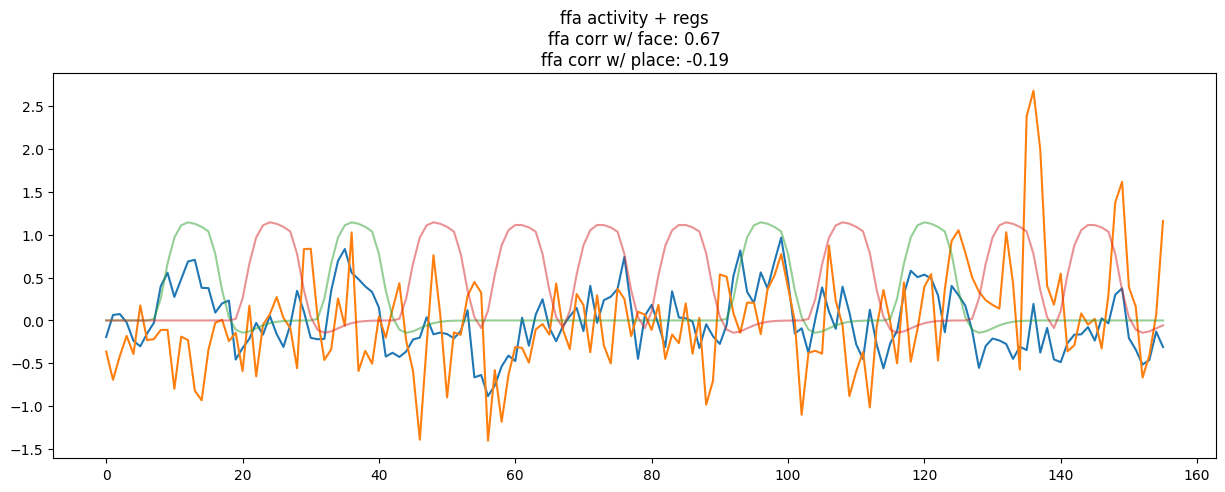

In [18]:
# Task regressors
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd

events_fn = f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 2.0 
n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
frame_times = (np.arange(n_scans) * t_r)

design_matrix = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

face_reg = design_matrix[['face','body']].values.sum(axis=1)
place_reg = design_matrix[['house', 'object', 'scene', 'scramble']].values.sum(axis=1)

ffa_im = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
ffa_scaler = utils.Scaler(func_ffa)
ffa_list = ffa_scaler.transform(func_ffa)
ffa_coords = torch.from_numpy(gm_coords[ffa_im.numpy().flatten()[gm_flat==1]==1,:])

plt.figure(figsize=(15,5))
plt.plot(ffa_list[:,:].mean(axis=0))
plt.plot(func_cf.mean(axis=0)-func_cf.mean(axis=0).mean())
plt.plot(face_reg,alpha=.5)
plt.plot(place_reg,alpha=.5)
plt.title('ffa activity + regs\n'+'ffa corr w/ face: {:.2f}\nffa corr w/ place: {:.2f}'.format(np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1],np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]))

In [19]:
ffa_list.shape

(58, 156)

In [20]:
# Correlation between FFA AVG and regressors before denoising
(np.corrcoef(func_ffa.mean(axis=0),face_reg)[0,1],
np.corrcoef(func_ffa.mean(axis=0),place_reg)[0,1],)

(0.626577669742678, -0.20437710027115766)

In [21]:
# Same thing, but correlate with every voxel first and then average the correlations. 
(np.array([np.corrcoef(func_ffa[v,:],face_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),
np.array([np.corrcoef(func_ffa[v,:],place_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),)

(0.23765441692530911, -0.06855689014202593)

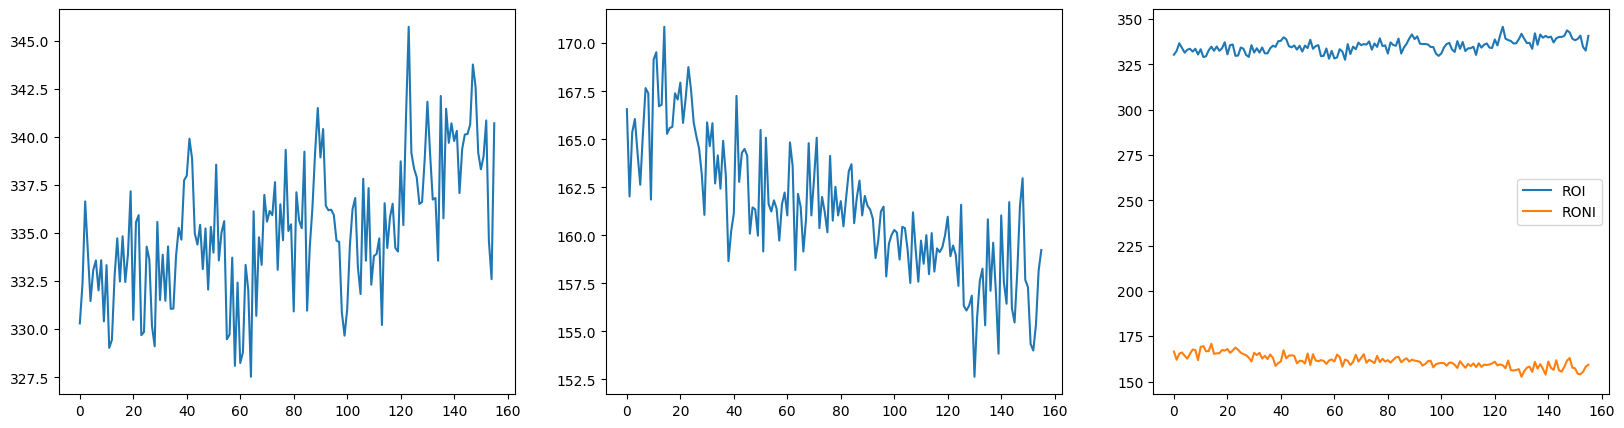

In [22]:
# Plot first voxel in ROI, RONI and both
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);plt.plot(func_gm[0,:])
plt.subplot(1,3,2);plt.plot(func_cf[0,:])
plt.subplot(1,3,3);plt.plot(func_gm[0,:]);plt.plot(func_cf[0,:]);plt.legend(['ROI','RONI'])

In [23]:
print(func_gm.shape)
print(func_cf.shape)

(44212, 156)
(9519, 156)


In [24]:
#Normalization of Data, remove voxels with std of 0 so it doesnt crash CVAE (from Yu Zhu's code)
func_gm, gm_coords = utils.remove_std0_coords(func_gm,gm_coords)
# func_gm = utils.remove_std0(func_gm)
func_cf = utils.remove_std0(func_cf)
print(func_gm.shape)
print(func_cf.shape)

(40867, 156)
(9096, 156)


In [25]:
len(gm_coords)

40867

In [26]:
# Apply scaler to ROI and RONI
obs_scale = utils.Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
print(obs_list.shape)
noi_scale = utils.Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)
print(noi_list.shape)

(40867, 156)
(9096, 156)


In [27]:
obs_aug = np.concatenate((obs_list,np.repeat(ffa_list,100,axis=0)),axis=0)

In [28]:
len(obs_list)

40867

In [29]:
len(obs_aug)

46667

In [30]:
pca = PCA(n_components = 20)

In [31]:
pca.fit(obs_list)

PCA(n_components=20)

In [32]:
obs_dimred = pca.fit_transform(obs_list)

In [33]:
obs_dimred.shape

(40867, 20)

# Gaussian Mixture Model of observations

In [34]:
%%time
# Fit GMM
gmm = GaussianMixture(n_components=20)
gmm.fit(obs_dimred)

CPU times: user 9.93 s, sys: 8.18 ms, total: 9.94 s
Wall time: 10.1 s


GaussianMixture(n_components=20)

In [35]:
log_prob = gmm.score_samples(pca.transform(obs_list[0:2]).reshape(2, -1))

In [36]:
print(-log_prob)

[39.04025039 37.74038006]


(array([2.10000e+01, 1.52300e+03, 1.94011e+05, 9.40320e+05, 2.78398e+05,
        4.67100e+03, 2.60000e+01, 0.00000e+00, 2.00000e+00, 4.00000e+00]),
 array([-6.8895464, -4.9556017, -3.021657 , -1.0877123,  0.8462324,
         2.780177 ,  4.714122 ,  6.6480665,  8.582011 , 10.515956 ,
        12.449901 ], dtype=float32),
 <BarContainer object of 10 artists>)

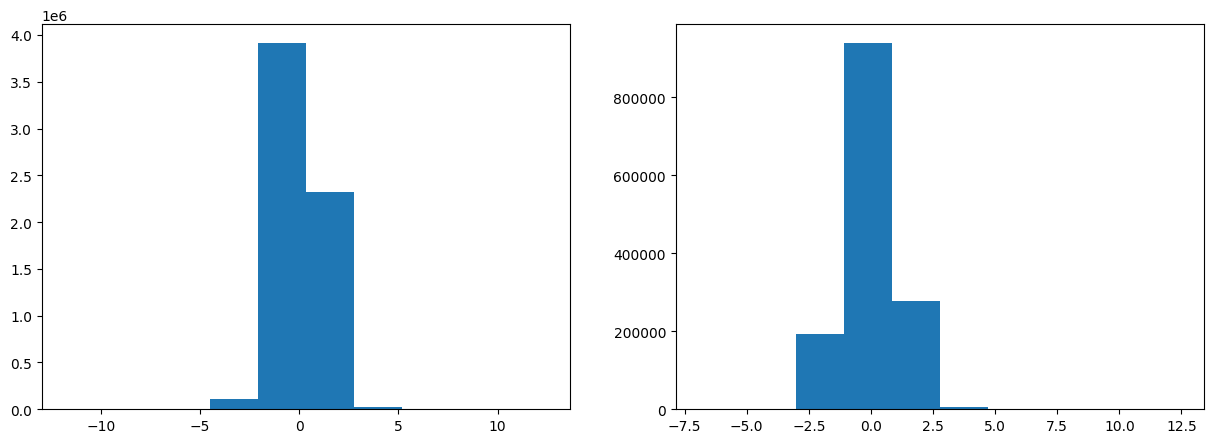

In [37]:
# Plot histograms for ROI and RONI
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())
plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [38]:
min_obs_list = obs_list.min()
max_obs_list = obs_list.max()

min_noi_list = noi_list.min()
max_noi_list = noi_list.max()

In [39]:
# Optiomal, additionaly norm the inputs to be 0-1
do_norm = False
if do_norm==True:
    obs_list = utils.norm(obs_list)
    noi_list = utils.norm(noi_list)

# Training the network

In [44]:
n_epochs = 100
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_20_53_53


In [ ]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss,loss_signal,loss_noise = model.loss_ncc(inputs_gm[:,0:156],inputs_cf,signal,noise)
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_weights-{sub}.weights')

In [47]:
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_weights-{sub}.weights')

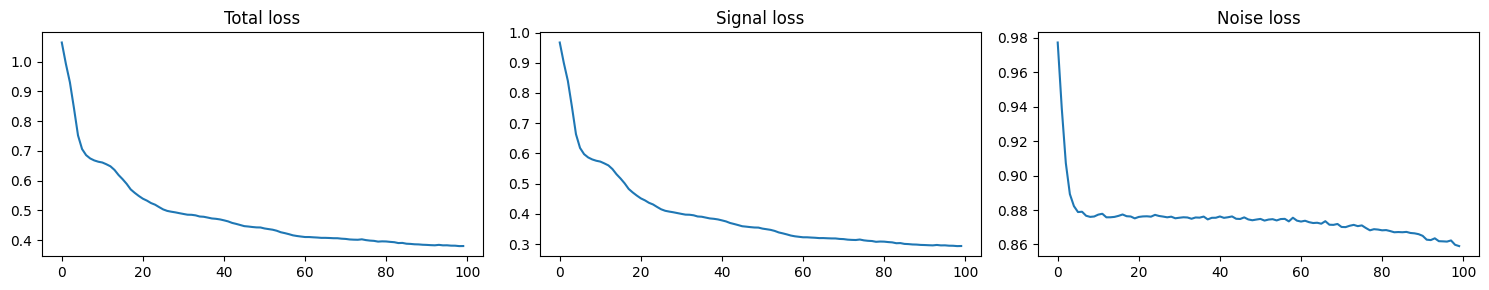

In [48]:
dashboard.adversarial_losses(track)

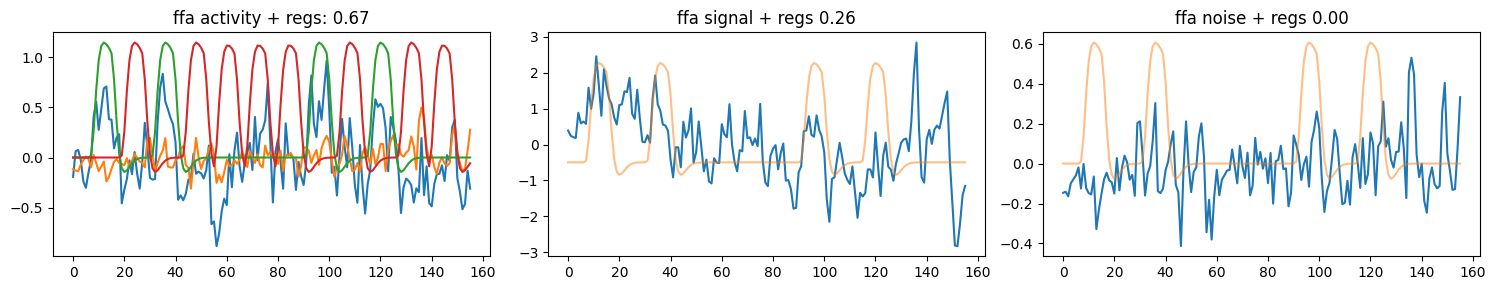

In [49]:
# dashboard.adversarial_ffa(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg);plt.show()
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

# Weighted loss using GMM

In [50]:
n_epochs = 100
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_20_56_52


In [51]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm[:,0:156],inputs_cf,signal,noise,pca,gmm,device)
        #loss,loss_signal,loss_noise = model.loss_ncc(inputs_gm[:,0:156],inputs_cf,signal,noise)
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_gmm_weights-{sub}.weights')

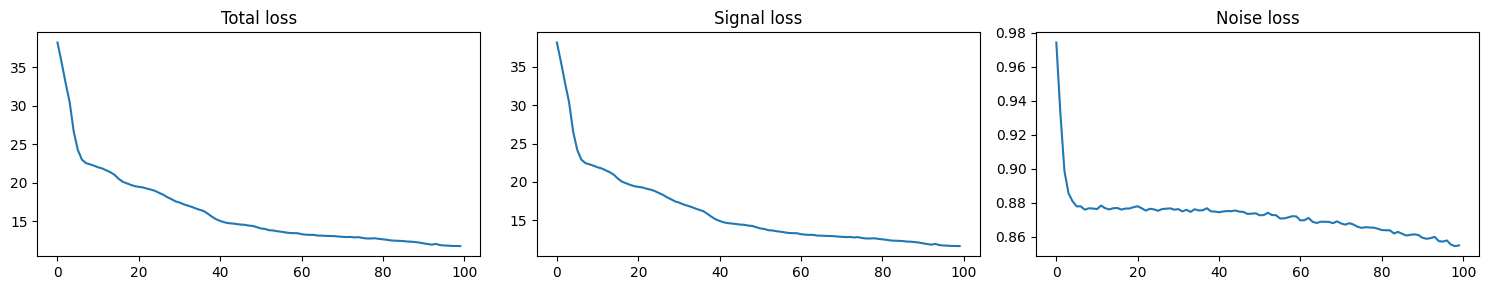

In [52]:
dashboard.adversarial_losses(track)

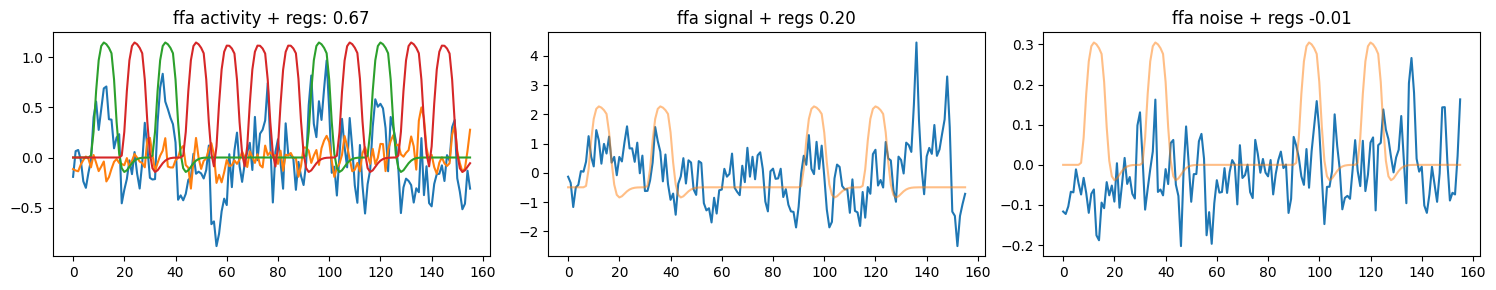

In [54]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

### Independent latent space loss

In [55]:
n_epochs = 100
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_21_02_18


In [56]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss,loss_signal,loss_noise = model.loss_ncc(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss_ind = model.independence_loss(z)
        loss = loss+loss_ind
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_indep_weights-{sub}.weights')

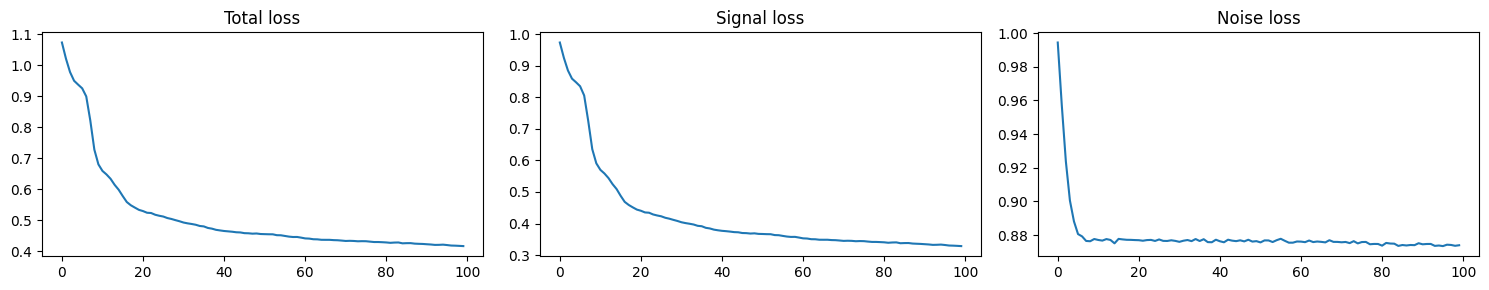

In [57]:
dashboard.adversarial_losses(track)

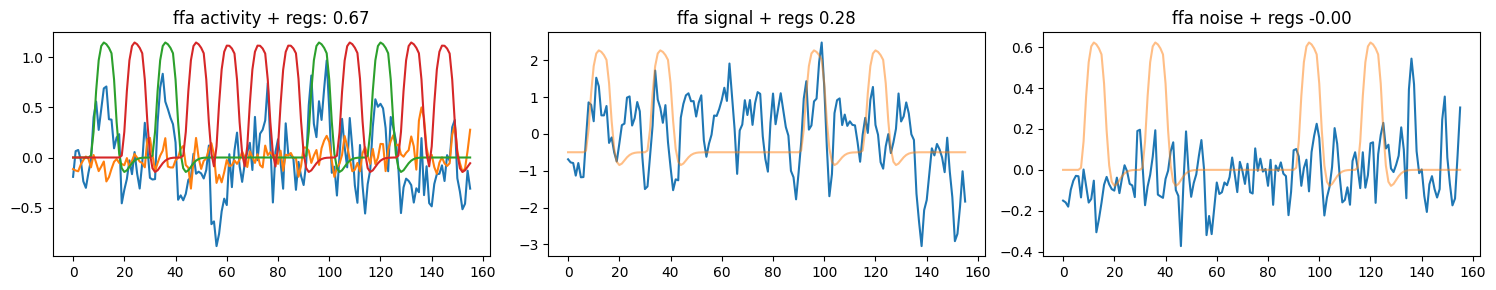

In [58]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

### Penalizing high frequencies loss

In [71]:
n_epochs = 100
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_21_12_29


In [72]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss,loss_signal,loss_noise = model.loss_ncc(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss_freq = models.high_frequency_penalty_loss_fc(signal)
        loss = loss+loss_freq
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_highfreq_weights-{sub}.weights')

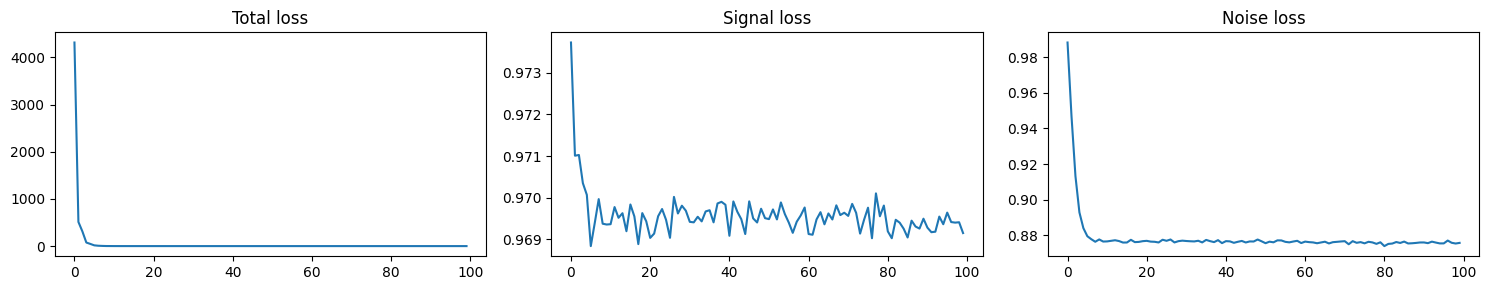

In [73]:
dashboard.adversarial_losses(track)

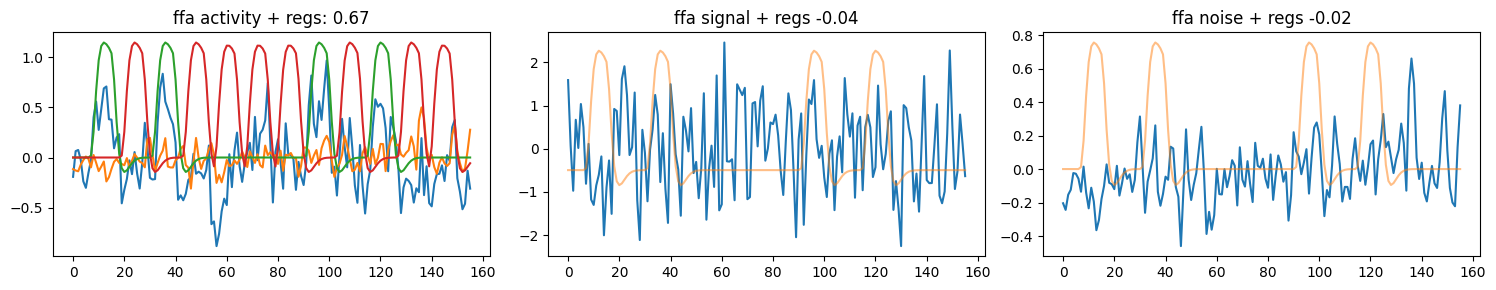

In [74]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

It looks that even when the number of dimensions is sufficiently high to make the signal loss become very small the network is still hallucinating responses to objects/scenes.

### MSE loss

In [76]:
n_epochs = 100
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_21_17_08


In [77]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss,loss_signal,loss_noise = model.loss_function(inputs_gm[:,0:156],inputs_cf,signal,noise)
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_mse-{sub}.weights')

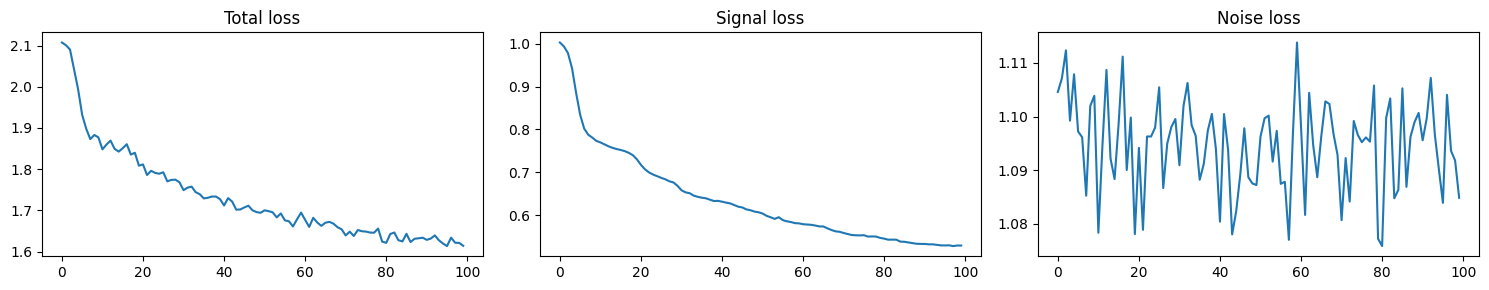

In [78]:
dashboard.adversarial_losses(track)

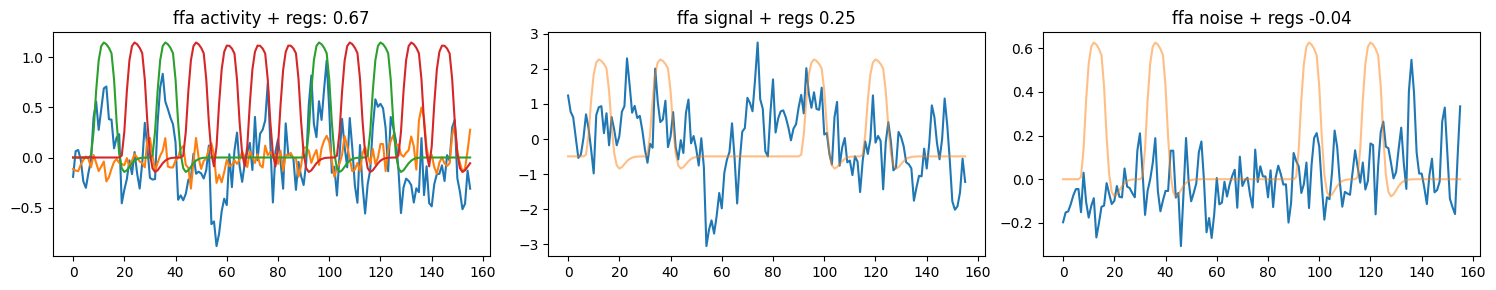

In [79]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

### MSE and NCC loss

In [85]:
n_epochs = 100
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_21_21_59


In [86]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc_gmm(inputs_gm[:,0:156],inputs_cf,signal,noise,pca,gmm,device)
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss = loss_ncc+loss_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_mse_ncc-{sub}.weights')

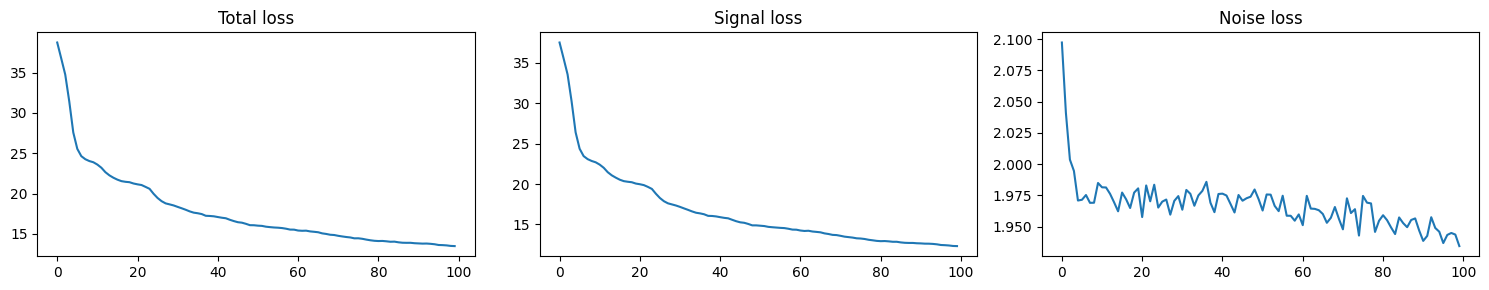

In [87]:
dashboard.adversarial_losses(track)

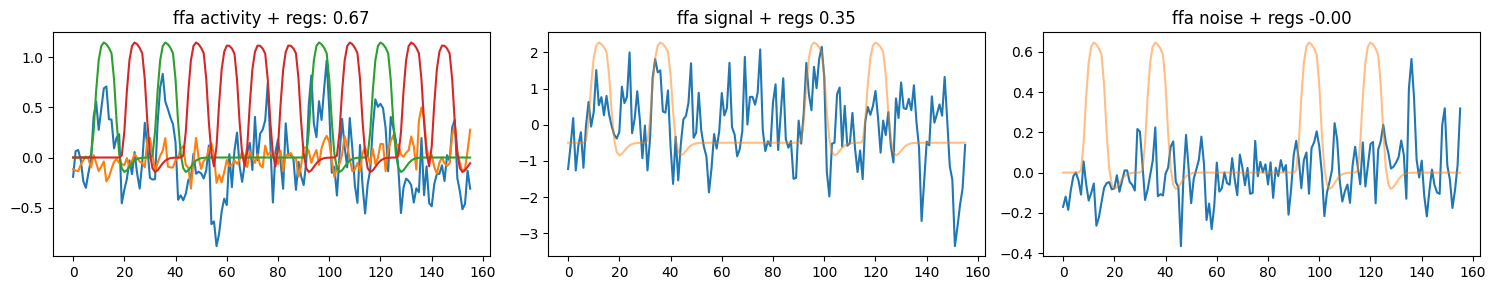

In [88]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

### MSE and NCC loss - longer training

In [89]:
n_epochs = 500
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_21_24_06


In [90]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc_gmm(inputs_gm[:,0:156],inputs_cf,signal,noise,pca,gmm,device)
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss = loss_ncc+loss_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_mse_ncc_long-{sub}.weights')

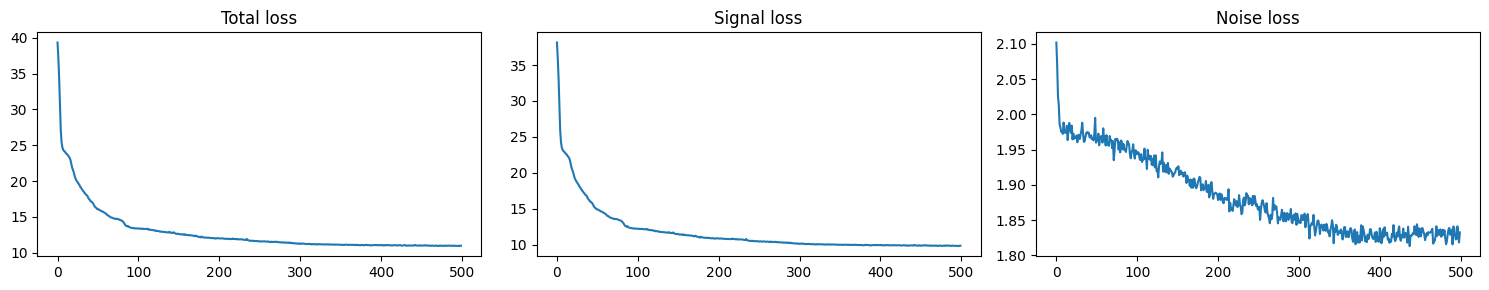

In [91]:
dashboard.adversarial_losses(track)

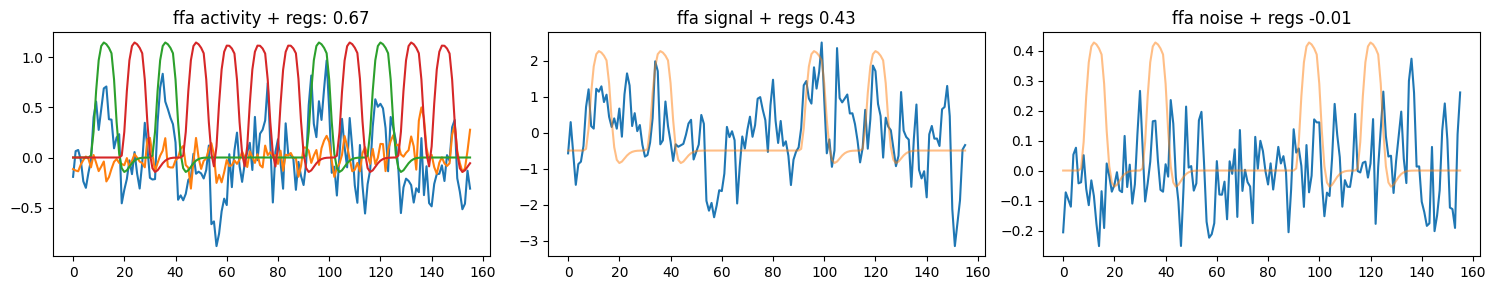

In [92]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

### MSE and NCC loss - longer training

In [93]:
n_epochs = 2000
batch_size = 1024
in_dim = func_cf.shape[1]

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
fc_dir = f'fc-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(fc_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/fully_connected_coords',fc_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Adversarial_fc_coords(in_dim)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

fc-sub-02-R2-T-2025_01_14_21_30_31


In [94]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc_gmm(inputs_gm[:,0:156],inputs_cf,signal,noise,pca,gmm,device)
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss = loss_ncc+loss_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_mse_ncc_longer-{sub}.weights')

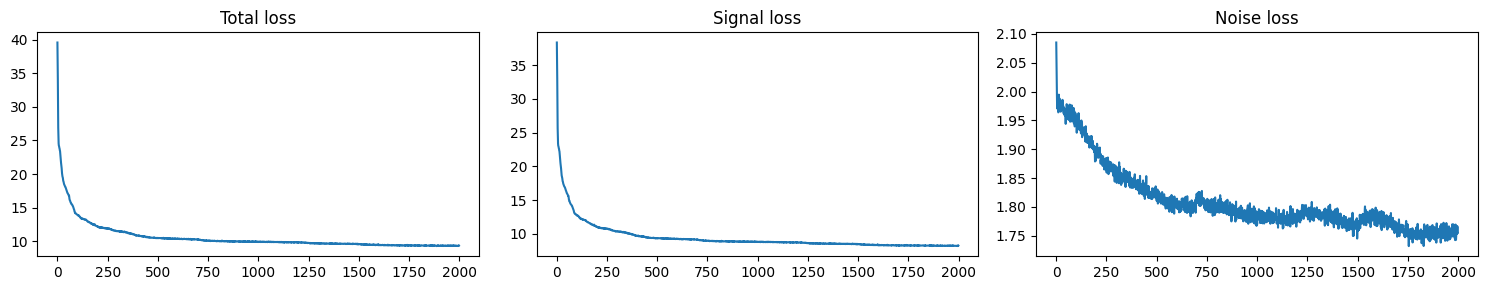

In [95]:
dashboard.adversarial_losses(track)

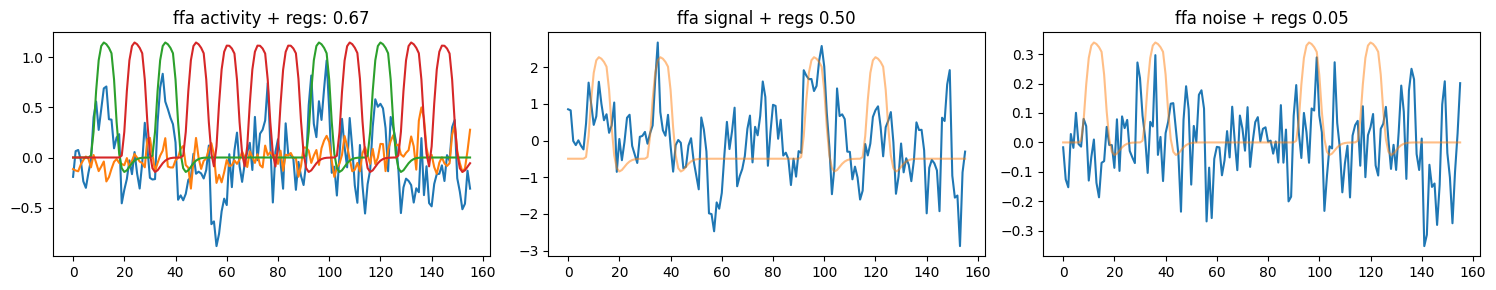

In [96]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

In [97]:
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc_gmm(inputs_gm[:,0:156],inputs_cf,signal,noise,pca,gmm,device)
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss = loss_ncc+loss_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_mse_ncc_longer_p2-{sub}.weights')

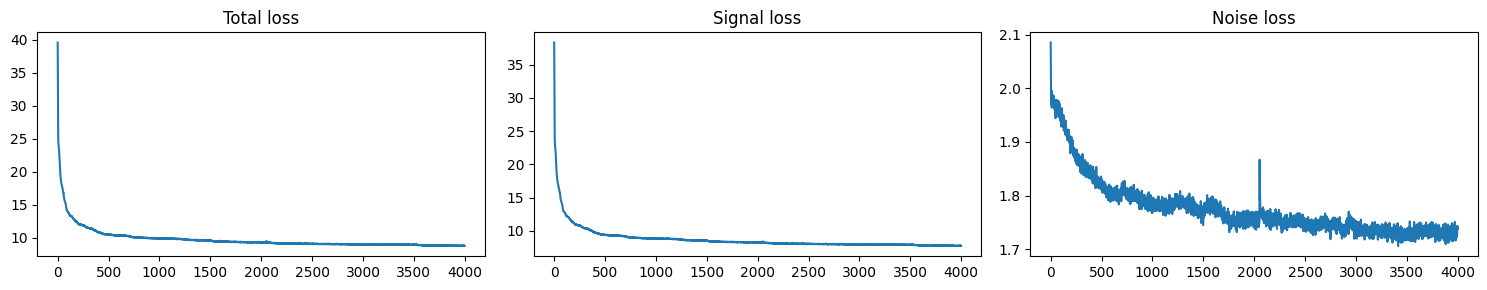

In [98]:
dashboard.adversarial_losses(track)

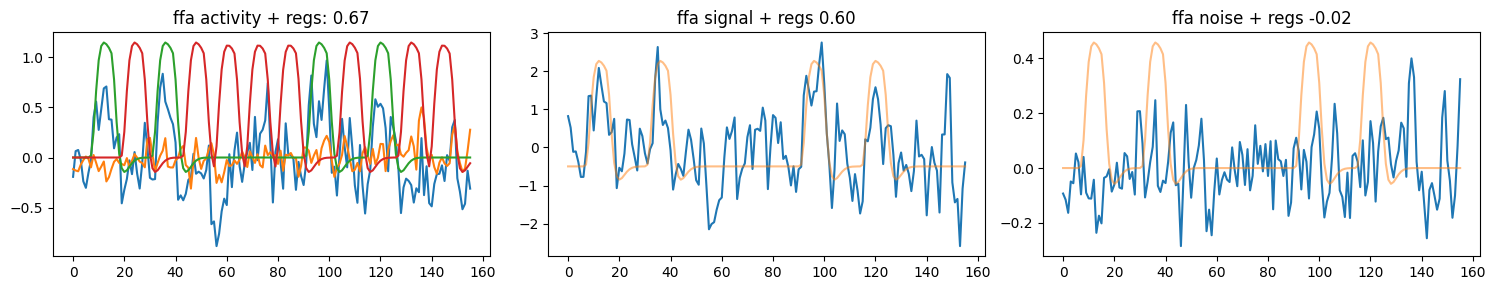

In [99]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()

In [100]:
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [signal, noise, z] = model.forward(inputs_gm)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc_gmm(inputs_gm[:,0:156],inputs_cf,signal,noise,pca,gmm,device)
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0:156],inputs_cf,signal,noise)
        loss = loss_ncc+loss_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

torch.save(model.state_dict(),f'../Data/StudyForrest/fully_connected_coords/{fc_dir}/fc_mse_ncc_longer_p2-{sub}.weights')

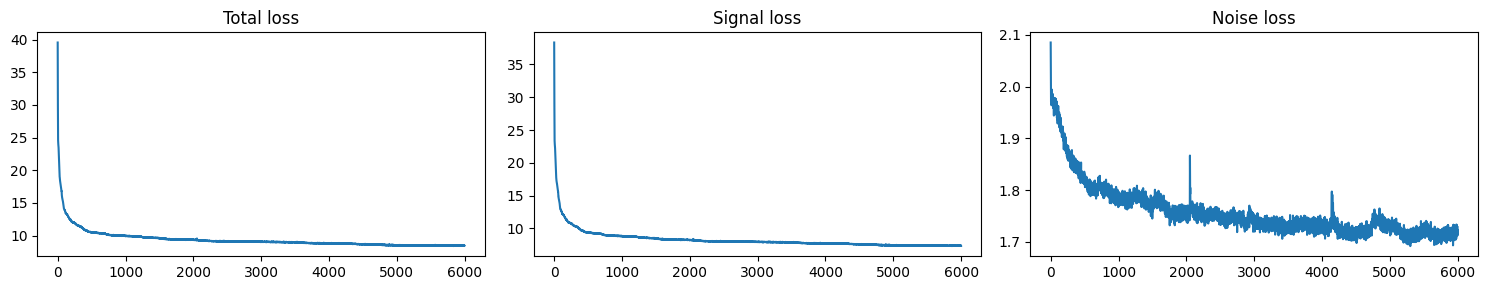

In [101]:
dashboard.adversarial_losses(track)

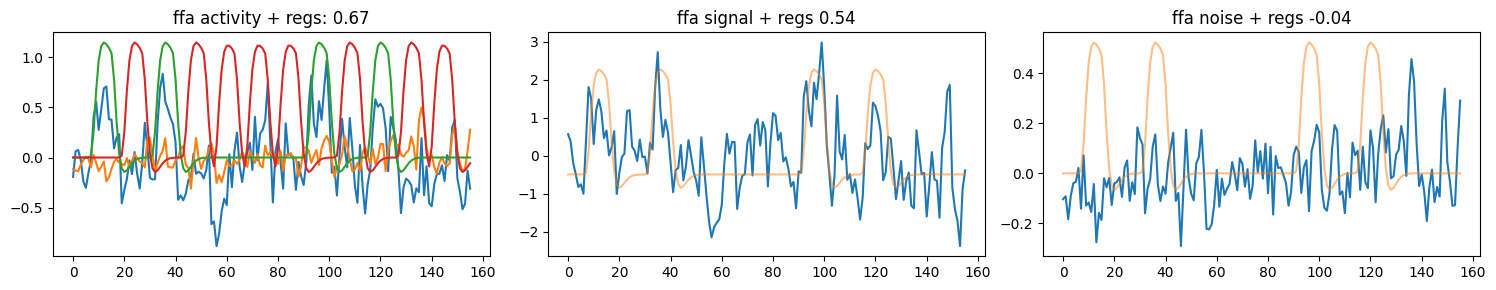

In [102]:
dashboard.adversarial_ffa_coords2_corr(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords);plt.show()